## Preparing Our Environement

### Get the Personalize boto3 Client

All of the code that we are using in this lab is Python, but any langugage supported by SageMaker could be used.  In this initial piece of code we are loading in the library dependencies that we need for the rest of the lab:

- **boto3** - standard Pything CLI library for the AWS SDK
- **json** - used to manipulate JSON structures used by our API calls
- **numpy** and **pandas** - standard libraries used by Data Scientists everywhere
- **time**, **datetime** and **pytz** - used for some time manipulation calls

These client handlers will be used throughout the lab, and you will see examples of other client handlers being instantiated for services such as Amazon S3 and IAM.

In [ ]:
import boto3

import json
import numpy as np
import pandas as pd
import time
import pytz
from datetime import datetime

personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

### Getting Read-to-User Personalize Assets
As for most of machine learning projects, this lab includes some tasks that may take a relatively long time to run, such as importing data into Personalize Dataset, training a Personalize solution and deploying a Personalize campaign. With the goal of optimizing time during this lab execution, this environment provides you with a pre-imported dataset, pre-trained solutions, and pre-deployed campaigns that will allow you to continue the exercise without needing to wait for long-running tasks. The code below gets the references to the ready-to-use assets that are going to be used during this lab.

In [ ]:
# Get Ready-to-Use Dataset Group
list_dataset_groups = personalize.list_dataset_groups()
for dataset_group in list_dataset_groups['datasetGroups']:
    if dataset_group['name'] == "immday-ready-personalize-recs-dataset-group":
        ready_dataset_group_arn = dataset_group['datasetGroupArn']
        break

# Get Ready-to-Use User Personalization Solution Version
list_solutions = personalize.list_solutions()
for solution in list_solutions['solutions']:
    if solution['name'] == "immday-ready-personalize-lab-recs-solution-hrnn":        
        list_solution_versions = personalize.list_solution_versions(
            solutionArn = solution['solutionArn']
        )
        ready_solution_version_arn = list_solution_versions['solutionVersions'][0]['solutionVersionArn']
        break

#Get Ready-to-Use User Personalization Campaign        
list_campaigns = personalize.list_campaigns()
for campaign in list_campaigns['campaigns']:
    if campaign['name'] == "immday-ready-personalize-lab-recs-campaign-hrnn":
        ready_campaign_arn = campaign['campaignArn']
        break
        
print("\nReady-to-Use Dataset Group ARN: \n" + ready_dataset_group_arn)
print("\nReady-to-Use User Personalization Solution Version ARN: \n" + ready_solution_version_arn)
print("\nReady-to-Use User Personalization Campaign ARN: \n" + ready_campaign_arn)

**Note**: Have in mind that you can still complete this lab using your own assets only, in case you have time for it (although it **is not recommended when you are executing the lab for the first time**). For doing so, please pay attention to the comments in the code cells below for replacing references to ready-to-use assets by those to the assets taht you created throughout the execution of this notebook.

## Data Preparation

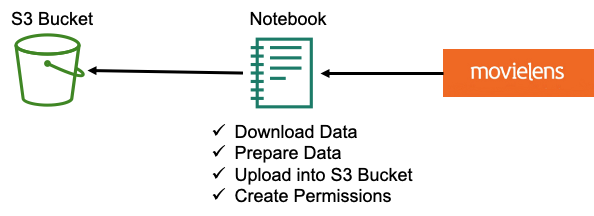

### Specify a Bucket for Our Data

Amazon Personalize only supports the uploading of data from an S3 bucket.  Hence, you need to create a new bucket or re-use an existing one.  If you need to create one the you **MUST** name your bucket before running this Code cell by editing the value for *bucket* in the code below.  You need to ensure that the bucket name is globally unique; for this lab we use *amazon-personalize-lab-*, followed by your account id, as that is likely to be unique.  Also, you **MUST** ensure that the bucket name contains the work *personalize*, as some IAM permissions later rely on this.


In case you get an error informing that the bucket already exists, we recommend you adding "*-*" followed by your name or initials at the end of the bucket name. If the bucket already exists - such as if you execute this code cell a second time - then it will not create a new bucket, and will not make any changes to the existing bucket.  If this happens unexpectedly then please check your own S3 page in the console to ensure that the bucket is in your account.

In [ ]:
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket = "amazon-personalize-lab-{}".format(account_id)

s3 = boto3.client('s3')
if boto3.resource('s3').Bucket(bucket).creation_date is None:
    s3.create_bucket(ACL = "private", Bucket = bucket)
    print("Creating bucket: {}".format(bucket))
else:
    print("Bucket {} already exists".format(bucket))

### Download, Prepare, and Upload Training Data

#### Download and Explore the Dataset

In this step we download the entire Movie Lens data set zip-file and unzip it - it will go in the same location as the physical notebook *.ipynb* file and the *u.item* file that you downloaded earlier.  We use the **pandas** library to read in the *u.data* file, which contains all of the movie reviews; this file consists of a movie ID, a user ID, a timestamp and a rating of between 1 and 5, and there are 100,000 unique reviews.

In [ ]:
!wget -N http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip
data = pd.read_csv('./ml-100k/u.data', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
pd.set_option('display.max_rows', 5)
data

#### Prepare and Upload Data

We don't actually need all of the review data.  We would like to recommend movies that a user would actually watch based upon what they and others have liked - we don't want to provide a rating between 1 and 5 for every movie in the data set!  Hence, we're going to use **pandas** to drop any reviews that are not > 3.6, and once we've done that also drop the review column - we're left with a subset of the original that contain 4- and 5-star ratings, which is basically indicating movies that the user really liked.  Of course, we could use all of the data, but this would lead to far greater data import and model training time.

Additionally, the reviews are quite old - they are from August 1997 to April 1998.  Some of the Amazon Personalize recipies react differently depending upon the age of the interactions - for instance, the _Similar Items_ recipe has several hyperparameters around how to handle 'decaying' interactions.  In order to make this lab easier, and not have to worry about these hyperparameters, we are shifting all of the review timestamps to be from August 2018 up until April 2019.

We then write that out to a file named as per that defined two steps previously, and upload it into our S3 bucket.  

This is the minimum amount of data that Amazon Personalize needs to train a model on - you need just 1000 rows of user/item/timestamp interactions, but we still have many 10s of thousands of entries left from our original 100,000 review dataset.  This file is known in Amazon Personalize as an **Interactions** data file.  Other data files are usable, such as ones that define additional metadata about the movies (such as year and genre) and another that defines demographic data about the user (such as age, gender and location).  In this lab we do not need them, but this information is available in the Movie Lens data set files that you have downloaded - you can create your own models based upon those at a later date.

In [ ]:
filename = "DEMO-movie-lens-100k.csv"              # file in S3 that will hold our model training data
data = data[data['RATING'] > 3]                    # keep only movies rated 3.6 and above
data = data[['USER_ID', 'ITEM_ID', 'TIMESTAMP']]   # select columns that match the columns in the schema below
data['TIMESTAMP'] = data['TIMESTAMP'] + 660833618  # make reviews end 1st April 2019 rather than 23rd April 1998
data.to_csv(filename, index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

### Creating Permissions

#### Attach policy to S3 bucket

Whilst we have created an S3 bucket, and our Interactions data file is sat there waiting to be imported, we have a problem - you may have full access to the bucket via the AWS console or APIs, but the Amazon Personalize service does not.  Hence, you have to create an S3 bucket policy that explicitly grants the service access to the `GetObject` and `ListBucket` commands in S3.  This code step creates such a policy and attaches it to your S3 bucket.

Note, any Personalize API calls that need to access you S3 bucket need to be done under the auspices of an IAM role that gives it permission - this step simply allows the service to access the bucket if, and only if, roles with appropriate permissions are used.

In [ ]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy));

#### Create Personalize S3 Role ARN

We need to define an IAM role that gives Personalize the ability to access S3 buckets - this is needed as well as the S3 bucket policy.

In [ ]:
iam = boto3.client("iam")

role_name = "PersonalizeRole"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes
# "personalize" or "Personalize".  If you would like to use a bucket with a different name,
# please consider creating and attaching a new policy that provides read access to your
# bucket or attaching the AmazonS3ReadOnlyAccess policy to this role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

time.sleep(30) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

## Importing Data into Personalize

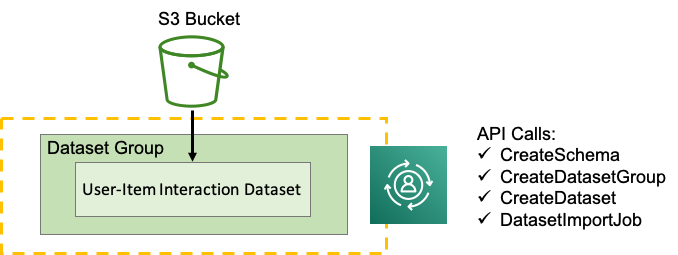

### Create Schema

Amazon Personalize uses *Schemas* to tell it how to interpret your data files.  This step defines the schema for our Interations file, which consists solely of a `USER_ID`, `ITEM_ID` and `TIMESTAMP`.  Once defined we pass it into Personalize for use.

In [ ]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "personalize-lab-recs-schema",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

### Create and Wait for Dataset Group

Now that we have defined a schema, and we have our Interactions data file, we can import the data into Personalize.  But first we have to define a *Dataset Group*, which is essentially a collection of imported data files, trained models and campaigns - each Dataset Group can contain one, and only one, Interaction, Item Metadata and User Demographic file.  When you train a model Personalize will use **all** data files present within its Dataset Group.

#### Create Dataset Group

In [ ]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "personalize-recs-dataset-group"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

#### Monitor Dataset Group and wait for ACTIVE Status

A number of Personalize API calls do take time, hence the calls are asynchronous.  Before we can continue with the next stage we need to poll the status of the `create_dataset_group()` call from the previous code cell - once the Dataset Group is active then we can continue.  **NOTE: this step should not take more than 1-2 minutes to complete**

In [ ]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    now = datetime.now(pytz.utc)
    elapsed = now - describe_dataset_group_response["datasetGroup"]["creationDateTime"]
    print("DatasetGroup: {}   (elapsed = {})".format(status, elapsed))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

### Create Dataset

We now have to create our dataset for the Interactions file.  This step does not actually import any data, rather it creates an internal structure for the data to be imported into.

In [ ]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = schema_arn,
    name="personalize-recs-dataset"
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

### Prepare, Create, and Monitor Dataset Import Job

#### Create Dataset Import Job

This pulls together the information that we have on our Dataset, on our S3 bucket, on our Interactions file and a suitable role for Personalize, and then triggers the actual data import process.

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "personalize-recs-dataset-import-job",
    datasetArn = dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, filename)
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

#### Monitor Dataset Import Job and Dataset Import Job Run and wait for an ACTIVE Status

We now poll the status of Interactions file import job, as until it is complete we cannot continue. 

**Note:** In order to check the status of your Dataset Import Job, you may need to execute the cell bellow multiple times. **This can take anything between 12-25 minutes to complete**

In [ ]:
status = None

describe_dataset_import_job_response = personalize.describe_dataset_import_job(
    datasetImportJobArn = dataset_import_job_arn
)

dataset_import_job = describe_dataset_import_job_response["datasetImportJob"]
now = datetime.now(pytz.utc)
elapsed = now - dataset_import_job["creationDateTime"]

if "latestDatasetImportJobRun" not in dataset_import_job:
    status = dataset_import_job["status"]
    print("DatasetImportJob: {}   (elapsed = {})".format(status, elapsed))
else:
    status = dataset_import_job["latestDatasetImportJobRun"]["status"]
    print("LatestDatasetImportJobRun: {}".format(status))

## Creating our Solution

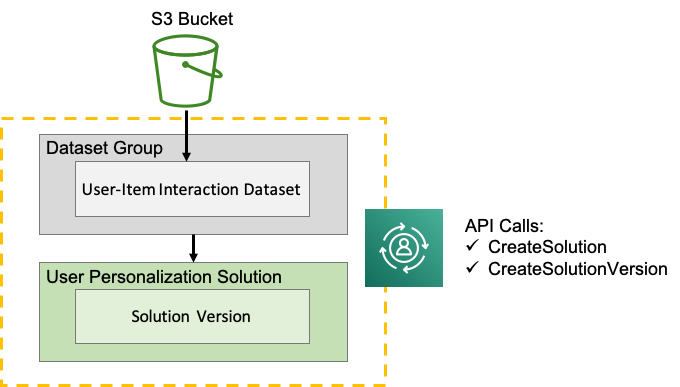

### Select Recipe

There are many different algorithm recipes available within Personalize, and this is a list of all supported algorithms.  We are going to select the standard HRNN recipe, which only needs the Interactions file and not the Item metadata or User demographic files.  Amazon Personalize has implemented a hierarchical recurrent neural network (HRNN), which is able to model the changes in user behavior.

Temporal modeling is important in recommendation systems because user intent and interests tend to change or drift with time. This drifting is hard to model with traditional approaches. For example, a common approach in factorization machines is to manually come up with a discounting function for distant interactions (distance measured by time). Such manual engineering of weights is human-effort intensive and is prone to inaccuracy.

The Amazon Personalize HRNN model, on the other hand, can take ordered user histories and make correct inferences. HRNN uses a gating mechanism to model the discount weights as a learnable function of the items and timestamp. The hierarchical component further improves temporal model efficiency and leads to higher accuracy.

In [ ]:
recipe_list = [
    "arn:aws:personalize:::recipe/aws-hrnn",
    "arn:aws:personalize:::recipe/aws-hrnn-coldstart",
    "arn:aws:personalize:::recipe/aws-hrnn-metadata",
    "arn:aws:personalize:::algorithm/aws-user-personalization",
    "arn:aws:personalize:::recipe/aws-personalized-ranking",
    "arn:aws:personalize:::recipe/aws-popularity-count",
    "arn:aws:personalize:::recipe/aws-sims"
]

recipe_arn = recipe_list[0]
print(recipe_arn)

### Create and Monitor Solution

With our data imported we can now train our ML solution.  This consists of just a single API to Personalise, where we specify the Dataset to use.

#### Create Solution

In [ ]:
create_solution_response = personalize.create_solution(
    name = "personalize-lab-recs-solution-hrnn",
#    datasetGroupArn = dataset_group_arn,   # Uncomment this line (and comment the next one) in case you want to use your own dataset group
    datasetGroupArn = ready_dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

#### Create Solution Version

In [ ]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

#### Monitor Solution wait to Have an ACTIVE Status

We now poll the status of solution creation job, as until it is complete we cannot continue. 

**Note:** In order to check the status of your Solution Version, you may need to execute the cell bellow multiple times. **This can take anything between 25-50 minutes to complete**

In [ ]:
status = None

describe_solution_version_response = personalize.describe_solution_version(
    solutionVersionArn = solution_version_arn
)

status = describe_solution_version_response["solutionVersion"]["status"]
now = datetime.now(pytz.utc)
elapsed = now - describe_solution_version_response["solutionVersion"]["creationDateTime"]

print("SolutionVersion: {}   (elapsed = {})".format(status, elapsed))

#### Get Metrics of Solution

Once the soluition is built you can look up the various metrics that Personalize provides - this allows you to see how well a model has been trained.  If you are re-training models after the acquisition of new data then these metrics can tell you if the models are training equally as well as before, better than before or worse than before, giving you the information that you need in order to decide whether or not to push a new model into Production.  You can also compare results across multiple different algorithm recipes, helping you choose the best performing one for you particular dataset.

You can find details on each of the metrics in our [documentation](https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html).

In [ ]:
get_solution_metrics_response = personalize.get_solution_metrics(
#    solutionVersionArn = solution_version_arn      # Uncomment this line (and comment the next one) in case you want to get metrics from your own Solution Version
    solutionVersionArn = ready_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

## Creating our Campaign

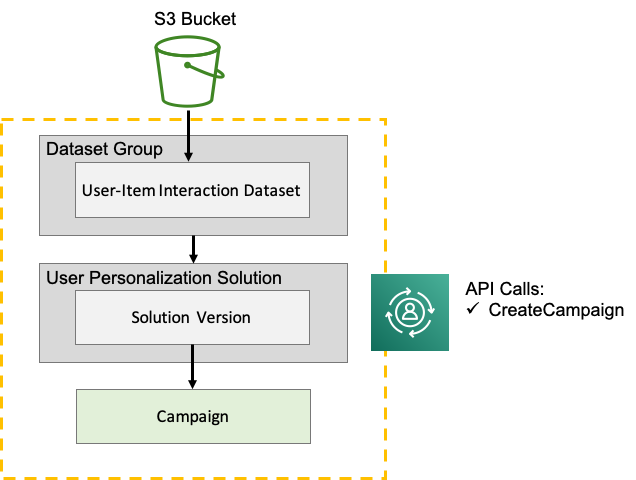

### Create and Wait for Campaign

A trained model is exactly that - just a model.  In order to use it you need to create an API endpoint, and you do this by creating a *Campaign*.  A Campaign simply provides the endpoint for a specific version of your model, and as such you are able to host endpoint for multiple versions of your models simultaneously, allowing you to do things like A/B testing of new models.

At the campaign level we specift the the minimum deployed size of the inference engine in terms of transactions per second - whilst this engine can scale up and down dynamically it will never scale below this level, but please note that pricing for Personalize is heavily based around the number of TPS currently deployed.

#### Create campaign

In [ ]:
create_campaign_response = personalize.create_campaign(
    name = "personalize-lab-recs-campaign",
#    solutionVersionArn = solution_version_arn,      # Uncomment this line (and comment the next one) in case you want use your own Solution Version
    solutionVersionArn = ready_solution_version_arn,
    minProvisionedTPS = 1
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

#### Wait for Campaign to Have ACTIVE Status

We now poll the status of Campaign creation job, as until it is complete we cannot continue.  

**Note:** In order to check the status of your Campaign, you may need to execute the cell bellow multiple times. **This can take anything between 3-15 minutes to complete**

In [ ]:
status = None

describe_campaign_response = personalize.describe_campaign(
    campaignArn = campaign_arn
)

status = describe_campaign_response["campaign"]["status"]
now = datetime.now(pytz.utc)
elapsed = now - describe_campaign_response["campaign"]["creationDateTime"]

print("Campaign: {}   (elapsed = {})".format(status, elapsed))

## Getting Recommendations

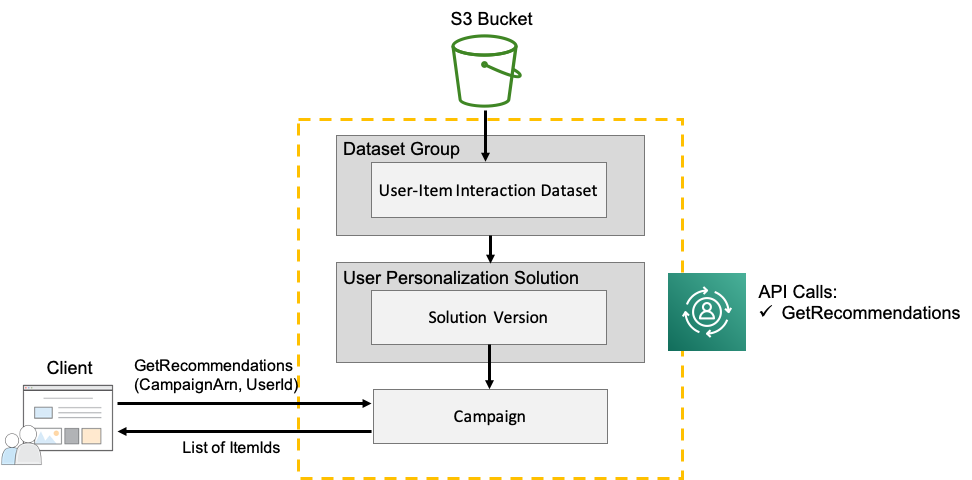

Finally, we have a deployed Campaign end-point, which hosts a specific version of our trained model - we are now able to make recommendation inference requests against it.  However, the Personalize recommendation calls just return itemID values - it returns no context around the title of the movie,  Hence, we use our pre-loaded version of the *u.item* file that contains the movie titles - we load in the file via **pandas** library calls and pick out a random userID and movieID from our training date.  This info is displayed, along with the name of the movie.

#### Select a User and an Item

In [ ]:
items = pd.read_csv('./u.item', sep='\t', usecols=[0,1], header=None)
items.columns = ['ITEM_ID', 'TITLE']

user_id, item_id, _ = data.sample().values[0]
item_title = items.loc[items['ITEM_ID'] == item_id].values[0][-1]
print("USER: {}".format(user_id))
print("ITEM: {}".format(item_title))

items

#### Call GetRecommendations

The last thing we do is actually make a Personalize recommendations inference call - as you can see from the Code cell this is literally a single line of code with a userID and itemID as input variables (although, strictly speaking, you only need the userID for the datasets that we have).

The inference call returns a list of up to 25 itemIDs from the training set - we take that and look up the corresponding movie titles from the *u.item* file and display them; this is far more useful than just a list of ID values.

In [ ]:
get_recommendations_response = personalize_runtime.get_recommendations(
#    campaignArn = campaign_arn,      # Uncomment this line (and comment the next one) in case you want to use your own Campaign
    campaignArn = ready_campaign_arn,
    userId = str(user_id)
)

item_list = get_recommendations_response['itemList']
title_list = [items.loc[items['ITEM_ID'] == np.int(item['itemId'])].values[0][-1] for item in item_list]

print("Recommendations: {}".format(json.dumps(title_list, indent=2)))

## Well done! You may now come back to the AWS Console